# Methodology
Sentinel-2 satellite imagery was used for the analysis which has a spatial resolution of 10m/pixel. An oil palm plantation situated in West Java Indonesia was selected as the area-of-interest due to it's sheer size amounting to 6.6km^2 or 660ha which will produce ample results with medium-resolution satellite imagery acquired from Sentinel-2 which can't be acheived by a smaller area-of-interest. Area-of-interest can be found in Open Street Map https://www.openstreetmap.org/edit#map=16/-6.5148/106.7299

This analysis aims to compare the oil palm plantation's Normalized Difference Vegetation Index (NDVI) between the dry & wet season to analyze the effects of precipitation on oil palm trees. A **higher NDVI** is associated with **higher rates of photosynthesis** & thus **higher production of Fresh Fruit Bunch (FFB) yield**. Therefore, **Precipitation** affects **NDVI** which affects **FFB yield**. On top of that, the time difference between dry & wet season should be minimal to ensure that the observed oil palm trees are in **similar growth phases** between the two seasons so that the growth phase has minimal impact on NDVI values to emphasize only the effects of precipitation on NDVI & thus FFB. Reference can be found in the following research paper https://www.researchgate.net/publication/281508567_Estimating_oil_palm_yields_using_vegetation_indices_derived_from_QuickBird

Steps 1-7 were executed in NDVI_Sentinel_Dry.ipynb & NDVI_Sentinel_Wet.ipynb respectively. Then step 8 is documented in Analysis.ipynb.
1. AOI defined in geojson & shapefile
2. Sentinel-2 Imagery of AOI downloaded via Sentinel Hub's API
3. RGB image created & masked with AOI bounding box
4. **NDVI calculated with ndvi = (Near-Infrared Band - Red Band) / (Near-Infrared Band + Red Band)**
5. NDVI image created & masked with AOI bounding box
6. Histogram of NDVI values were plotted
7. Steps 2-6 repeated with different temporal timeframe
8. Histogram of NDVI values for AOI during different temporal timeframes compared ie between dry & wet season

Constant variable = growth phase of oil palm trees (assumption)

Manipulated variable = seasonal weather (time) ~ precipitation

Responding variable = NDVI ~ FFB Yield

In [1]:
#Import packages
import numpy as np
import geopandas as gpd
import folium 
import rasterio as rio 
import fiona
import rasterio
import rasterio.mask
from rasterio.plot import show
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [2]:
#Sentinel hub API credentials
user = '' 
password = '' 
api = SentinelAPI(user, password, 'https://scihub.copernicus.eu/dhus')

In [3]:
#Geojson of Area-of-interest
#Converted to WKT format for Sentinel hub API query
footprint = geojson_to_wkt(read_geojson('data/map.geojson'))
footprint

'POLYGON((106.7496 -6.5179,106.7502 -6.5174,106.7501 -6.5163,106.7496 -6.5138,106.7517 -6.5131,106.7519 -6.5119,106.7500 -6.5117,106.7491 -6.5097,106.7477 -6.5074,106.7447 -6.5058,106.7413 -6.5046,106.7363 -6.5070,106.7362 -6.5096,106.7316 -6.5085,106.7337 -6.5050,106.7270 -6.5011,106.7276 -6.5040,106.7249 -6.5054,106.7248 -6.5097,106.7163 -6.5112,106.7114 -6.5071,106.7063 -6.5064,106.7079 -6.5164,106.7169 -6.5154,106.7181 -6.5196,106.7222 -6.5201,106.7258 -6.5230,106.7301 -6.5213,106.7351 -6.5223,106.7357 -6.5225,106.7359 -6.5201,106.7375 -6.5205,106.7394 -6.5237,106.7434 -6.5230,106.7433 -6.5197,106.7452 -6.5186,106.7465 -6.5182,106.7472 -6.5189,106.7479 -6.5186,106.7484 -6.5191,106.7488 -6.5186,106.7497 -6.5192,106.7506 -6.5185,106.7496 -6.5179))'

In [4]:
#Shapefile of Area-of-interest
#Converted into geopandas format for rasterio masking of AOI ie cropping the AOI from the satellite imagery
nReserve = gpd.read_file('data/POLYGON.shx')
nReserve['geometry']

0    POLYGON ((106.7496291 -6.5179488, 106.7502486 ...
Name: geometry, dtype: geometry

In [5]:
#Area-of-interest visualized on a basemap 
m = folium.Map([-6.5278297, 106.7295628], zoom_start=13)
boundsdata = 'data/map.geojson'
folium.GeoJson(boundsdata).add_to(m)
m

# AOI BETWEEN 01/08/2019 - 01/10/19
The palm oil plantation in the dry season which occured during the massive haze over Indonesia, Malaysia & Singapore.
Weather data with humidity levels can be found at https://www.timeanddate.com/weather/@1642673/historic?month=9&year=2019

In [6]:
#Sentinel hub API Query
#Querying for satellite imagery scenes containing AOI & between 01/08/2019 - 01/10/2019
products = api.query(footprint,
                     date = ('20190801', '20191001'),
                     platformname = 'Sentinel-2',
                     processinglevel = 'Level-2A',
                     cloudcoverpercentage = (0,10)
                    )

In [7]:
#Satellite imagery scenes which includes AOI & satisfies the API query parameters
products_gdf = api.to_geodataframe(products)
products_gdf_sorted = products_gdf.sort_values(['cloudcoverpercentage'], ascending=[True])
products_gdf_sorted

,title,link,link_alternative,link_icon,summary,beginposition,endposition,ingestiondate,orbitnumber,relativeorbitnumber,...,processingbaseline,processinglevel,producttype,platformname,size,filename,level1cpdiidentifier,identifier,uuid,geometry
88d6d13e-2371-4cc0-abd9-65c817f831d9,S2A_MSIL2A_20190922T025541_N0213_R032_T48MXT_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-09-22T02:55:41.024Z, Instrument: MS...",2019-09-22 02:55:41.024,2019-09-22 02:55:41.024,2019-09-22 08:19:15.606,22194,32,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.06 GB,S2A_MSIL2A_20190922T025541_N0213_R032_T48MXT_2...,S2A_OPER_MSI_L1C_TL_SGS__20190922T062725_A0221...,S2A_MSIL2A_20190922T025541_N0213_R032_T48MXT_2...,88d6d13e-2371-4cc0-abd9-65c817f831d9,(POLYGON ((105.9059828740654 -7.32484128020348...
f75feaf0-f257-4756-9fd3-614867d4d951,S2A_MSIL2A_20190912T025541_N0213_R032_T48MXT_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-09-12T02:55:41.024Z, Instrument: MS...",2019-09-12 02:55:41.024,2019-09-12 02:55:41.024,2019-09-12 09:36:10.051,22051,32,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.06 GB,S2A_MSIL2A_20190912T025541_N0213_R032_T48MXT_2...,S2A_OPER_MSI_L1C_TL_SGS__20190912T063125_A0220...,S2A_MSIL2A_20190912T025541_N0213_R032_T48MXT_2...,f75feaf0-f257-4756-9fd3-614867d4d951,(POLYGON ((105.9059828740654 -7.32484128020348...
b67ff4e5-3cb0-4f45-a929-4be114e16a75,S2B_MSIL2A_20190818T025549_N0213_R032_T48MXT_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-08-18T02:55:49.024Z, Instrument: MS...",2019-08-18 02:55:49.024,2019-08-18 02:55:49.024,2019-08-18 14:52:42.260,12785,32,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.05 GB,S2B_MSIL2A_20190818T025549_N0213_R032_T48MXT_2...,S2B_OPER_MSI_L1C_TL_EPAE_20190818T071338_A0127...,S2B_MSIL2A_20190818T025549_N0213_R032_T48MXT_2...,b67ff4e5-3cb0-4f45-a929-4be114e16a75,(POLYGON ((105.9059828740654 -7.32484128020348...
69e54c3a-ab67-4e90-8184-a67db2042153,S2B_MSIL2A_20190808T025549_N0213_R032_T48MXT_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-08-08T02:55:49.024Z, Instrument: MS...",2019-08-08 02:55:49.024,2019-08-08 02:55:49.024,2019-08-08 10:23:58.268,12642,32,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.03 GB,S2B_MSIL2A_20190808T025549_N0213_R032_T48MXT_2...,S2B_OPER_MSI_L1C_TL_SGS__20190808T081023_A0126...,S2B_MSIL2A_20190808T025549_N0213_R032_T48MXT_2...,69e54c3a-ab67-4e90-8184-a67db2042153,(POLYGON ((105.9059828740654 -7.32484128020348...
f096679d-d918-4e02-8c48-f2920b902170,S2A_MSIL2A_20190813T025551_N0213_R032_T48MXT_2...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2019-08-13T02:55:51.024Z, Instrument: MS...",2019-08-13 02:55:51.024,2019-08-13 02:55:51.024,2019-08-13 16:41:06.544,21622,32,...,02.13,Level-2A,S2MSI2A,Sentinel-2,1.04 GB,S2A_MSIL2A_20190813T025551_N0213_R032_T48MXT_2...,S2A_OPER_MSI_L1C_TL_EPAE_20190813T073033_A0216...,S2A_MSIL2A_20190813T025551_N0213_R032_T48MXT_2...,f096679d-d918-4e02-8c48-f2920b902170,(POLYGON ((105.9059828740654 -7.32484128020348...


In [ ]:
#Satellite imagery downloaded
#The scene was captured on 12/09/2019 which was intensely dry with a recorded humidity level of 22% at 1pm ie the lowest of the year for AOI
api.download("f75feaf0-f257-4756-9fd3-614867d4d951")

In [8]:
# Open Band 4, 3 and 2 with Rasterio
R10 = 'data/S2A_MSIL2A_20190912T025541_N0213_R032_T48MXT_20190912T065935.SAFE/GRANULE/L2A_T48MXT_A022051_20190912T031402/IMG_DATA/R10m'
b4 = rio.open(R10+'/T48MXT_20190912T025541_B04_10m.jp2') # Red band
b3 = rio.open(R10+'/T48MXT_20190912T025541_B03_10m.jp2') # Green band
b2 = rio.open(R10+'/T48MXT_20190912T025541_B02_10m.jp2') # Blue band

In [ ]:
# Create an RGB image by combining Red, Green & Blue band
with rio.open('data/RGB.tiff','w',driver='Gtiff', width=b4.width, height=b4.height, 
              count=3,crs=b4.crs,transform=b4.transform, dtype=b4.dtypes[0]) as rgb:
    rgb.write(b2.read(1),1) 
    rgb.write(b3.read(1),2) 
    rgb.write(b4.read(1),3) 
    rgb.close()

In [9]:
# Check EPSG projection of coordinate system for satellite imagery scene
b4.crs

CRS.from_epsg(32748)

In [10]:
# Check EPSG projection of coordinate system for AOI bounding box
nReserve.crs

{'init': 'epsg:4326'}

In [11]:
# Convert EPSG projection for AOI bounding box to be compatible with EPSG for satellite imagery scene
nReserve_proj = nReserve.to_crs({'init': 'epsg:32748'})

/opt/conda/lib/python3.6/site-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


In [12]:
nReserve_proj

,landuse,geometry
0,orchard ...,"POLYGON ((693469.3410006873 9279204.293907411,..."


In [13]:
nReserve_proj.geometry

0    POLYGON ((693469.3410006873 9279204.293907411,...
Name: geometry, dtype: geometry

In [14]:
#Open & Crop RGB image with bounding box of AOI
#Image is cropped to optimize computational resources by excluding areas outside of AOI
with rio.open("data/RGB.tiff") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry, crop=True)
    out_meta = src.meta

In [15]:
#Create RGB_masked with cropped RGB image
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

In [16]:
#Metadata of original RGB Image
src.meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 3,
 'crs': CRS.from_epsg(32748),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 9300040.0)}

In [17]:
#Metadata of cropped RGB Image
out_meta

{'driver': 'GTiff',
 'dtype': 'uint16',
 'nodata': None,
 'width': 505,
 'height': 251,
 'count': 3,
 'crs': CRS.from_epsg(32748),
 'transform': Affine(10.0, 0.0, 688680.0,
        0.0, -10.0, 9281080.0)}

In [18]:
out_image.shape[1]

251

In [19]:
out_image.shape[2]

505

In [ ]:
#Save cropped RGB Image
with rio.open("data/RGB_masked.tiff", "w", **out_meta) as dest:
    dest.write(out_image)

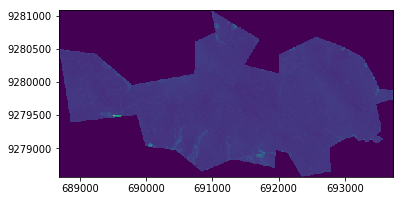

In [20]:
#Visualize RGB_masked
fp = 'data/RGB_masked.tiff'
raster = rio.open(fp)
show(raster)

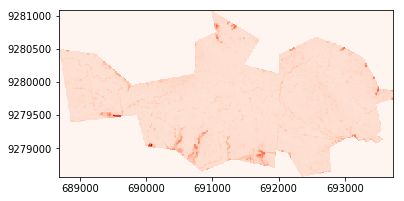

In [21]:
#Visualize red band
show((raster, 3), cmap='Reds')

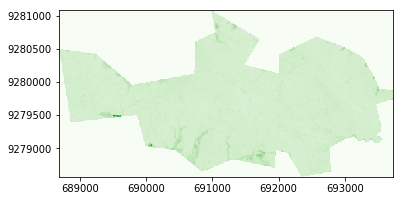

In [22]:
#Visualize green band
show((raster, 2), cmap='Greens')

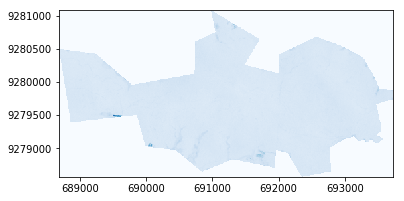

In [23]:
#Visualize blue band
show((raster, 1), cmap='Blues')

*****NDVI Calculations*****

In [24]:
# Open b4 and b8
b4 = rio.open(R10+'/T48MXT_20190912T025541_B04_10m.jp2')
b8 = rio.open(R10+'/T48MXT_20190912T025541_B08_10m.jp2')

# read Red(b4) and NIR(b8) as arrays
red = b4.read()
nir = b8.read()

In [25]:
# Allow division by zero
np.seterr(divide='ignore', invalid='ignore')

# Calculate ndvi
ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)

In [26]:
# check range NDVI values, excluding NaN
np.nanmin(ndvi), np.nanmax(ndvi)

(-0.8975409836065574, 0.9993825254708243)

In [27]:
ndvi.shape

(1, 10980, 10980)

In [28]:
ndvi

array([[[ 0.70772108,  0.68      ,  0.74059946, ...,  0.29039952,
          0.44220183,  0.47681916],
        [ 0.75347913,  0.74912544,  0.75866702, ...,  0.40376851,
          0.48101707,  0.32681564],
        [ 0.76705245,  0.77296753,  0.75980392, ...,  0.32853403,
          0.41687817,  0.26929558],
        ...,
        [-0.088     , -0.05714286, -0.11909263, ...,  0.30541597,
          0.34556575,  0.30021834],
        [ 0.02783726, -0.09752066, -0.14341847, ...,  0.48588771,
          0.42430704,  0.38143177],
        [ 0.05376344, -0.0787172 ,  0.00724638, ...,  0.51340616,
          0.51371571,  0.4802294 ]]])

In [ ]:
# Write the NDVI image
meta = b4.meta
meta.update(driver='GTiff')
meta.update(dtype=rio.float32)

with rio.open('data/NDVI.tiff', 'w', **meta) as dst:
    dst.write(ndvi.astype(rio.float32))

In [29]:
#Open & Crop NDVI image with bounding box of AOI
with rio.open("data/NDVI.tiff") as src:
    out_image, out_transform = rio.mask.mask(src, nReserve_proj.geometry, crop=True)
    out_meta = src.meta

In [30]:
#Create NDVI_masked with cropped RGB image
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

In [31]:
src.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 10980,
 'height': 10980,
 'count': 1,
 'crs': CRS.from_epsg(32748),
 'transform': Affine(10.0, 0.0, 600000.0,
        0.0, -10.0, 9300040.0)}

In [32]:
out_meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 505,
 'height': 251,
 'count': 1,
 'crs': CRS.from_epsg(32748),
 'transform': Affine(10.0, 0.0, 688680.0,
        0.0, -10.0, 9281080.0)}

In [ ]:
#Save NDVI_masked
with rio.open("data/NDVI_masked.tiff", "w", **out_meta) as dest:
    dest.write(out_image)

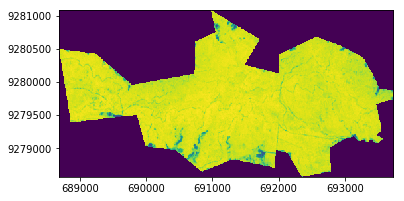

In [33]:
#Visualize NDVI
fp = 'data/NDVI_masked.tiff'
raster = rio.open(fp)
show(raster)

In [34]:
#Utility functions

"""
The NDVI values will range from -1 to 1. You want to use a diverging color scheme to visualize the data,
and you want to center the colorbar at a defined midpoint. The class below allows you to normalize the colorbar.
"""

class MidpointNormalize(colors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)
    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    Credit: Joe Kington, http://chris35wills.github.io/matplotlib_diverging_colorbar/
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))


# Set min/max values from NDVI range for image (excluding NAN)
# set midpoint according to how NDVI is interpreted: https://earthobservatory.nasa.gov/Features/MeasuringVegetation/
min=np.nanmin(ndvi)
max=np.nanmax(ndvi)
mid=0.1

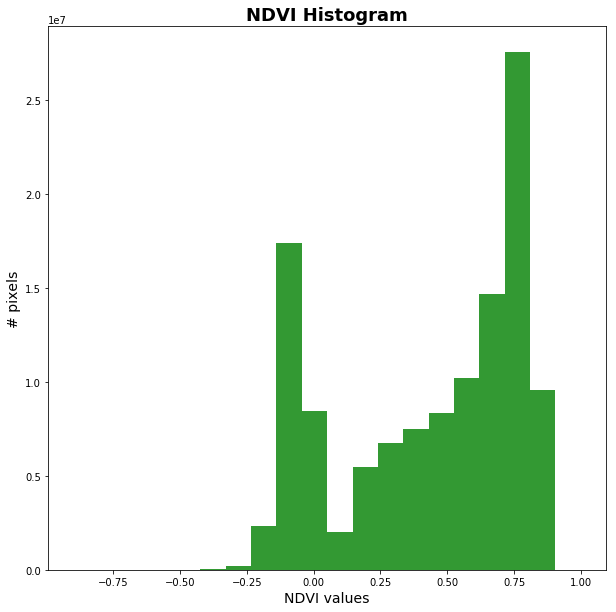

In [35]:
#NDVI Histogram
fig2 = plt.figure(figsize=(10,10))
ax = fig2.add_subplot(111)

plt.title("NDVI Histogram", fontsize=18, fontweight='bold')
plt.xlabel("NDVI values", fontsize=14)
plt.ylabel("# pixels", fontsize=14)


x = ndvi[~np.isnan(ndvi)]
numBins = 20
ax.hist(x,numBins,color='green',alpha=0.8)

fig2.savefig("data/ndvi-dry-histogram.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

In [36]:
sum_ndvi = sum(x)
sum_ndvi

52898017.12245479